from collections import Counter
# Cricket Image Classification: Feature Extraction & Model Training

This notebook demonstrates the complete pipeline for classifying cricket image cells (Ball, Bat, Stump, Background).

## Steps:
1.  **Setup**: Install dependencies.
2.  **Data Loading**: Load images and labels.
3.  **Feature Visualization**: Inspect HOG, Color, and Shape features.
4.  **Feature Extraction**: Build the feature matrix.
5.  **Model Training**: Train SVM, Random Forest, and MLP classifiers.
6.  **Evaluation**: Analyze performance metrics.

## 1. Setup & Dependencies

In [ ]:
!pip install scikit-image opencv-python pandas matplotlib scikit-learn

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import exposure
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

# Configuration
IMG_WIDTH = 800
IMG_HEIGHT = 600
GRID_ROWS = 8
GRID_COLS = 8
CELL_W = IMG_WIDTH // GRID_COLS
CELL_H = IMG_HEIGHT // GRID_ROWS

# Paths (Adjust if using Google Drive)
PROCESSED_DIR = "processed_images"
LABELS_FILE = "labels.csv"

## 2. Data Loading
Ensure `processed_images` folder and `labels.csv` are uploaded to the Colab environment.

In [2]:
def load_data(labels_file, image_dir):
    if not os.path.exists(labels_file):
        print(f"Error: {labels_file} not found.")
        return None
    
    df = pd.read_csv(labels_file)
    print(f"Loaded labels for {len(df)} images.")
    return df

df = load_data(LABELS_FILE, PROCESSED_DIR)
df.head()

Loaded labels for 61 images.


,ImageFileName,TrainOrTest,c01,c02,c03,c04,c05,c06,c07,c08,...,c55,c56,c57,c58,c59,c60,c61,c62,c63,c64
0,Screenshot 2025-11-02 104948.jpg,Train,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,d776ac3d-0ba3-47be-84dc-24af35be3c4c.jpg,Train,0,0,0,0,0,0,0,0,...,0,0,0,0,3,3,2,0,0,0
2,a644afcb-a5f8-4400-8606-d08f8c8ae9ba.jpg,Train,0,0,0,2,0,0,0,0,...,0,0,0,0,0,3,0,0,0,0
3,pexels-arsal-point-356971417-31131697.jpg,Train,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,3,0,0,0
4,Screenshot-2024-05-22-at-4.04.57-PM-1024x675.png,Train,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 3. Feature Visualization
Let's inspect the features for a single cell to understand what the model sees.

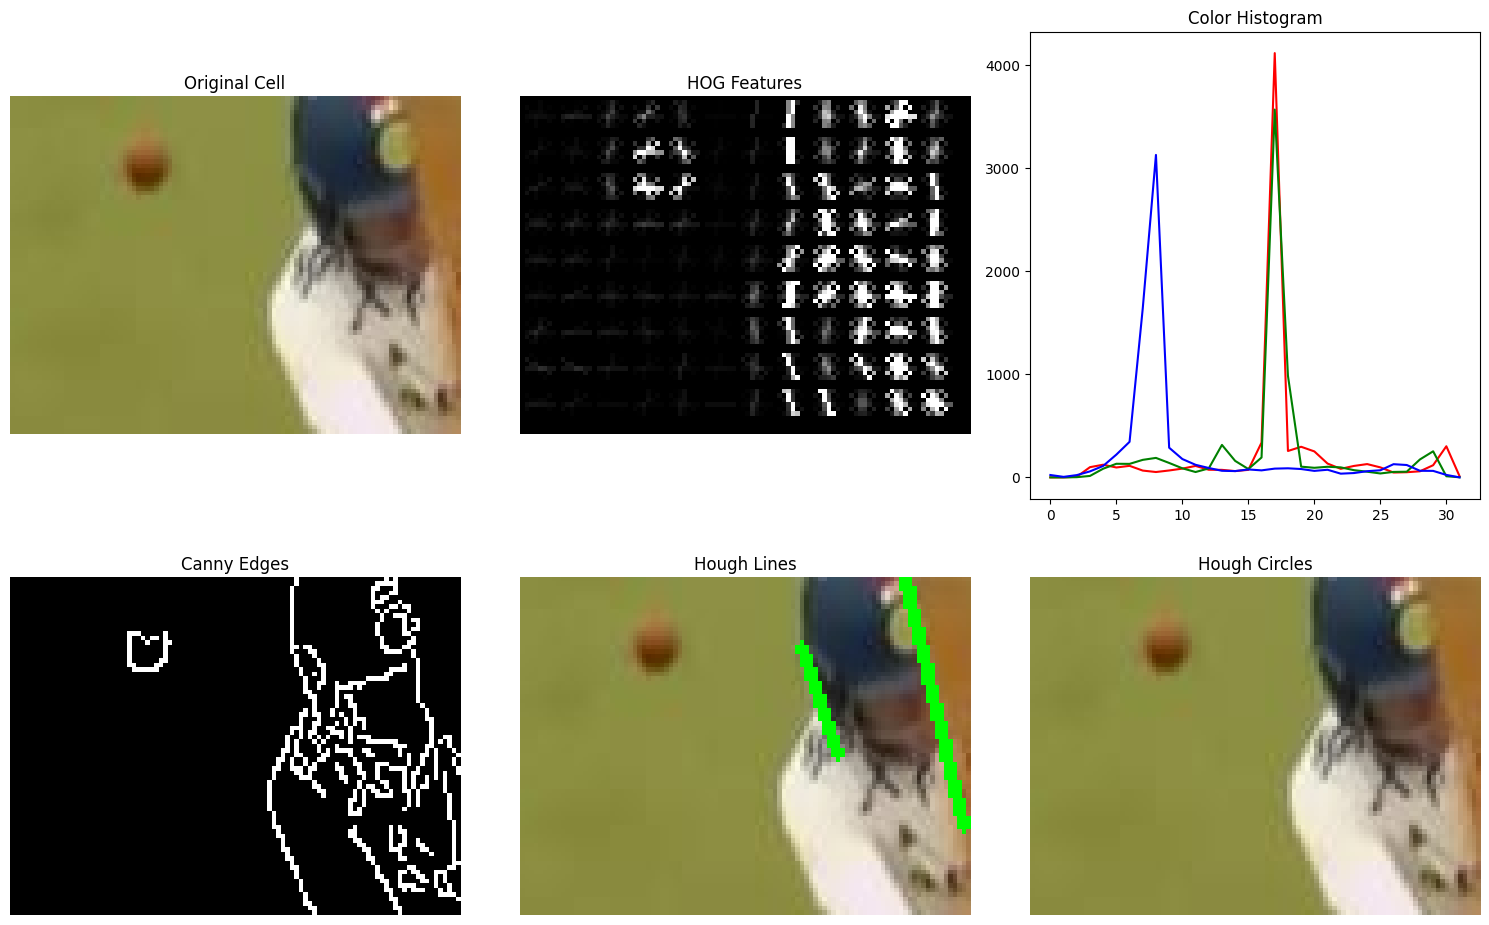

In [3]:
def visualize_features(image_name, row_idx, col_idx):
    img_path = os.path.join(PROCESSED_DIR, image_name)
    if not os.path.exists(img_path):
        print(f"Image {image_name} not found.")
        return
        
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Extract Cell
    x1 = col_idx * CELL_W
    y1 = row_idx * CELL_H
    x2 = x1 + CELL_W
    y2 = y1 + CELL_H
    cell = img[y1:y2, x1:x2]
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # 1. Original
    axes[0, 0].imshow(cell)
    axes[0, 0].set_title("Original Cell")
    axes[0, 0].axis('off')
    
    # 2. HOG
    fd, hog_image = hog(cell, orientations=9, pixels_per_cell=(8, 8),
                        cells_per_block=(2, 2), visualize=True, channel_axis=-1)
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
    axes[0, 1].imshow(hog_image_rescaled, cmap='gray')
    axes[0, 1].set_title("HOG Features")
    axes[0, 1].axis('off')
    
    # 3. Color Histogram
    axes[0, 2].set_title("Color Histogram")
    colors = ('r', 'g', 'b')
    for i, color in enumerate(colors):
        hist = cv2.calcHist([cell], [i], None, [32], [0, 256])
        axes[0, 2].plot(hist, color=color)
        
    # 4. Edge Detection
    gray = cv2.cvtColor(cell, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, 50, 150)
    axes[1, 0].imshow(edges, cmap='gray')
    axes[1, 0].set_title("Canny Edges")
    axes[1, 0].axis('off')
    
    # 5. Hough Lines
    lines_img = cell.copy()
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=30, minLineLength=20, maxLineGap=10)
    if lines is not None:
        for line in lines:
            x1_l, y1_l, x2_l, y2_l = line[0]
            cv2.line(lines_img, (x1_l, y1_l), (x2_l, y2_l), (0, 255, 0), 2)
    axes[1, 1].imshow(lines_img)
    axes[1, 1].set_title("Hough Lines")
    axes[1, 1].axis('off')
    
    # 6. Hough Circles
    circles_img = cell.copy()
    circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, dp=1.2, minDist=20,
                               param1=50, param2=30, minRadius=5, maxRadius=50)
    if circles is not None:
        circles = np.uint16(np.around(circles))
        for i in circles[0, :]:
            cv2.circle(circles_img, (i[0], i[1]), i[2], (0, 255, 0), 2)
            cv2.circle(circles_img, (i[0], i[1]), 2, (255, 0, 0), 3)
    axes[1, 2].imshow(circles_img)
    axes[1, 2].set_title("Hough Circles")
    axes[1, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize a sample cell (Row 4, Col 4 of first image)
if df is not None and not df.empty:
    visualize_features(df.iloc[0]['ImageFileName'], 3, 3)

## 4. Feature Extraction
We will now iterate through all images and extract features for every labeled cell.

In [4]:
def extract_features(df):
    features_list = []
    labels_list = []
    meta_list = []
    
    print("Starting feature extraction...")
    
    for idx, row in df.iterrows():
        img_name = row['ImageFileName']
        img_path = os.path.join(PROCESSED_DIR, img_name)
        
        if not os.path.exists(img_path):
            continue
            
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        for i in range(64):
            label = row[f"c{i+1:02d}"]
            if label == 0: # Skip background/unlabeled if desired, or keep as class 0
                # For this task, let's keep 0 as 'Background' class
                pass
                
            r = i // GRID_COLS
            c = i % GRID_COLS
            
            x1 = c * CELL_W
            y1 = r * CELL_H
            x2 = x1 + CELL_W
            y2 = y1 + CELL_H
            
            cell = img[y1:y2, x1:x2]
            
            # --- Feature 1: HOG ---
            fd = hog(cell, orientations=9, pixels_per_cell=(8, 8),
                     cells_per_block=(2, 2), visualize=False, channel_axis=-1)
            
            # --- Feature 2: Color Histogram ---
            hist_features = []
            for ch in range(3):
                hist = cv2.calcHist([cell], [ch], None, [32], [0, 256])
                hist = cv2.normalize(hist, hist).flatten()
                hist_features.extend(hist)
                
            # --- Feature 3: Shape Counts ---
            gray = cv2.cvtColor(cell, cv2.COLOR_RGB2GRAY)
            edges = cv2.Canny(gray, 50, 150)
            
            lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=30, minLineLength=20, maxLineGap=10)
            num_lines = len(lines) if lines is not None else 0
            
            circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, dp=1.2, minDist=20,
                                       param1=50, param2=30, minRadius=5, maxRadius=50)
            num_circles = len(circles[0, :]) if circles is not None else 0
            
            # Combine
            combined = np.concatenate([fd, hist_features, [num_lines, num_circles]])
            
            features_list.append(combined)
            labels_list.append(label)
            meta_list.append((img_name, i))
            
        if (idx + 1) % 5 == 0:
            print(f"Processed {idx + 1} images...")
            
    return np.array(features_list), np.array(labels_list), meta_list

X, y, meta = extract_features(df)
print(f"Feature Matrix Shape: {X.shape}")
print(f"Labels Shape: {y.shape}")

Starting feature extraction...
Processed 5 images...
Processed 10 images...
Processed 15 images...
Processed 20 images...
Processed 25 images...
Processed 30 images...
Processed 35 images...
Processed 40 images...
Processed 45 images...
Processed 50 images...
Processed 55 images...
Processed 60 images...
Feature Matrix Shape: (3904, 3266)
Labels Shape: (3904,)


## 4.1 Exploratory Data Analysis (EDA)
Let's analyze the class distribution and feature correlations.

## 4.1 Data Splitting
We split the data into training and testing sets before EDA to avoid data leakage.

In [5]:
# Split Data
X_train, X_test, y_train, y_test, meta_train, meta_test = train_test_split(X, y, meta, test_size=0.2, random_state=42)

# Scale Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Train set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

Train set: (3123, 3266)
Test set: (781, 3266)


In [ ]:
import seaborn as sns

# 1. Class Distribution (Train Data)
plt.figure(figsize=(8, 5))
sns.countplot(x=y_train)
plt.title("Class Distribution (Training Set)")
plt.xlabel("Class Label (0: None, 1: Ball, 2: Bat, 3: Stump)")
plt.ylabel("Count")
plt.show()

# 2. Feature Correlation (Subset - Train Data)
# We have many features, let's look at HOG mean vs Color mean
hog_means = np.mean(X_train[:, :324], axis=1)
color_means = np.mean(X_train[:, 324:324+768], axis=1)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=hog_means, y=color_means, hue=y_train, palette='viridis', alpha=0.6)
plt.title("Feature Scatter: HOG Mean vs Color Mean (Train)")
plt.xlabel("Mean HOG Value")
plt.ylabel("Mean Color Value")
plt.legend(title="Class")
plt.show()

## 4.2 Handling Class Imbalance (SMOTE)
We use SMOTE to oversample the minority classes in the training set.

In [ ]:
from collections import Counter
from imblearn.over_sampling import SMOTE

print("Original class distribution:", Counter(y_train))

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

print("Resampled class distribution:", Counter(y_train_resampled))

# Update training data to use resampled data for models
# Note: X_train_scaled was already scaled before SMOTE if we follow the split cell logic
# But wait, the split cell does scaling AFTER splitting usually. Let's check the split cell content.


In [9]:
# 1. Support Vector Machine
print("Training SVM...")
svm_model = SVC(kernel='rbf', C=10, gamma='scale', class_weight='balanced')
svm_model.fit(X_train_resampled, y_train_resampled)
svm_pred = svm_model.predict(X_test_scaled)
    svm_train_pred = svm_model.predict(X_train_scaled)
    print("svm Train Accuracy:", accuracy_score(y_train, svm_train_pred))
print("SVM Test Accuracy:", accuracy_score(y_test, svm_pred))

Training SVM...
SVM Accuracy: 0.9052496798975672


In [7]:
# 2. Random Forest
print("Training Random Forest...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)
rf_pred = rf_model.predict(X_test_scaled)
    rf_train_pred = rf_model.predict(X_train_scaled)
    print("rf Train Accuracy:", accuracy_score(y_train, rf_train_pred))
print("Random Forest Test Accuracy:", accuracy_score(y_test, rf_pred))

Training Random Forest...
Random Forest Accuracy: 0.8975672215108835


In [ ]:
# 3. MLP (Neural Network)
print("Training MLP...")
mlp_model = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
mlp_model.fit(X_train_resampled, y_train_resampled)
mlp_pred = mlp_model.predict(X_test_scaled)
    mlp_train_pred = mlp_model.predict(X_train_scaled)
    print("mlp Train Accuracy:", accuracy_score(y_train, mlp_train_pred))
print("MLP Test Accuracy:", accuracy_score(y_test, mlp_pred))

## 6. Evaluation
Visualizing the performance of the best model (likely Random Forest or SVM).

SVM Classification Report:
              precision    recall  f1-score   support

        None       0.91      0.99      0.95       701
        Ball       0.00      0.00      0.00         7
         Bat       0.00      0.00      0.00        35
       Stump       0.71      0.26      0.38        38

    accuracy                           0.91       781
   macro avg       0.41      0.31      0.33       781
weighted avg       0.85      0.91      0.87       781



/Users/suvadeepghosh/Documents/pml-project-image-labeler/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/suvadeepghosh/Documents/pml-project-image-labeler/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/suvadeepghosh/Documents/pml-project-image-labeler/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divisio

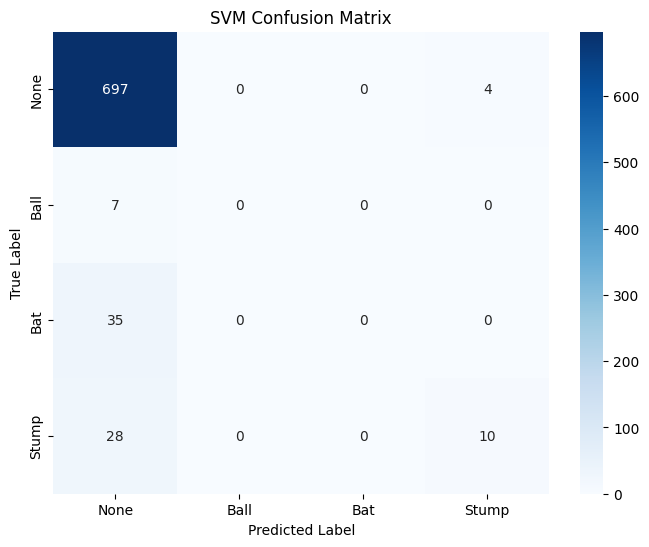

Random Forest Classification Report:
              precision    recall  f1-score   support

        None       0.90      1.00      0.95       701
        Ball       0.00      0.00      0.00         7
         Bat       0.00      0.00      0.00        35
       Stump       0.00      0.00      0.00        38

    accuracy                           0.90       781
   macro avg       0.22      0.25      0.24       781
weighted avg       0.81      0.90      0.85       781



/Users/suvadeepghosh/Documents/pml-project-image-labeler/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/suvadeepghosh/Documents/pml-project-image-labeler/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/suvadeepghosh/Documents/pml-project-image-labeler/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divisio

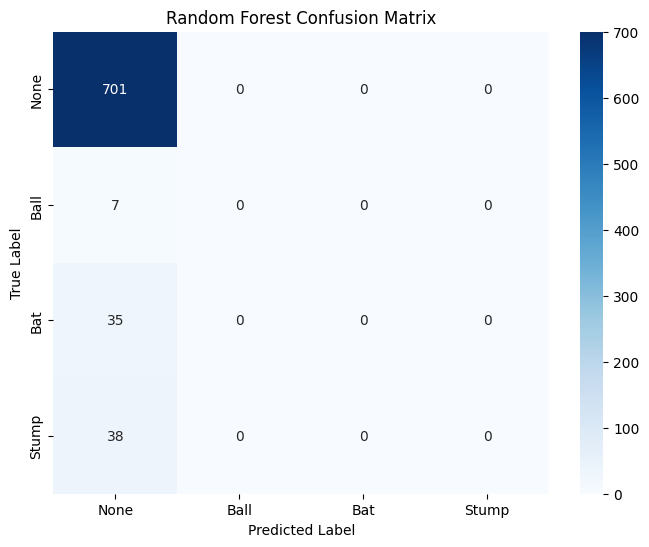

In [10]:
def evaluate_model(model, X_train, y_train, X_test, y_test, name):
    print(f"--- {name} Evaluation ---")
    
    # Train Metrics
    y_train_pred = model.predict(X_train)
    print(f"Train Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
    
    # Test Metrics
    y_test_pred = model.predict(X_test)
    print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
    
    print("\nTest Classification Report:")
    print(classification_report(y_test, y_test_pred, target_names=['None', 'Ball', 'Bat', 'Stump']))
    
    plot_confusion_matrix(y_test, y_test_pred, f"{name} Confusion Matrix (Test)")

evaluate_model(svm_model, X_train_scaled, y_train, X_test_scaled, y_test, "SVM")
evaluate_model(rf_model, X_train_scaled, y_train, X_test_scaled, y_test, "Random Forest")
evaluate_model(mlp_model, X_train_scaled, y_train, X_test_scaled, y_test, "MLP")

## 7. Save Predictions
Save the test set predictions to a CSV file for review.

In [22]:
# Predict on ALL data to generate complete image labels
print("Predicting on full dataset...")
X_scaled = scaler.transform(X)
all_pred = rf_model.predict(X_scaled)

# Create results DataFrame in wide format (matching labels.csv)
results_map = {}

for (img, cell_idx), pred_lbl in zip(meta, all_pred):
    if img not in results_map:
        results_map[img] = [0] * 64
    results_map[img][cell_idx] = pred_lbl

csv_rows = []
for img, preds in results_map.items():
    row = {'ImageFileName': img, 'TrainOrTest': 'Predicted'}
    for i, val in enumerate(preds):
        row[f'c{i+1:02d}'] = val
    csv_rows.append(row)

predicted_df = pd.DataFrame(csv_rows)
# Ensure columns are in correct order
cols = ['ImageFileName', 'TrainOrTest'] + [f'c{i+1:02d}' for i in range(64)]
predicted_df = predicted_df[cols]

predicted_df.to_csv("predicted_labels.csv", index=False)
print(f"Saved predictions for {len(predicted_df)} images to predicted_labels.csv")
predicted_df.head()

NameError: name 'meta_test' is not defined